# LDA Model experiments

The purpose of this notebook is to demonstrate building an LDA model.  Example code is also provide to perform an optimal topic no search.  The actual code for execution can be found in the src/models directory.

# Basic concepts and building blocks for the experiments

## Build dictionaries
**Check this at the end to confirm it is still the same**
This notebook relies on preprocessed emails.  During preprocessing the following are performed **Check Accuracy**:
1. Clears formatting.
1. Removes email addresses and URLs in the bodies
1. Expand contractions
1. Tokenize the body.
1. Lemmatize the tokens
1. Remove stopwords from the tokens.


The preprocessed mails are stored in a JSON format intended to be loaded into the Email_Forensic_Processor class.   However, json can be used directly to load and extract the relevant data. This may be more efficient than loading it into the class.

The first step during model building for LDA is to build dictionaries.  The preprocessing prepared the words of interest,  after which dictionaries are compiled in the form of a Bag of Words (BOW).

In the preprocessing we used two ways to extract tokens.  The first called "common" in the code to follow involves normal extraction by means of regular expressions.  The second called "pos" makes use of Spacy's Part of Speech tagging to extract only:
- Nouns
- Proper Nouns
- Verbs



In [26]:
import os
import re
import os
import tempfile
import math
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import json
from pprint import pprint

from tqdm import tqdm

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

import plotly.graph_objects as go


################ Function definitions ###############
# A helper function which loads the json email and returns it as a dictionary
def loadMail(filename):
    with open (filename, "r") as inputFile:
        return json.load(inputFile)
################ End Function definitions ###############


########## Code: Loading Dictionaries #########
def build_dictionaries(subdir, pre_pend_filter = "", limit = 10000):
    # This technique requires dictionaries to fit in available memory.
    # It is good for experimenting, but not for general purpose use if lots of data will be processed.
    bow_docs_common = []
    texts_common = []
    bow_docs_pos = []
    texts_pos = []
    files = []
    dictionary_common = Dictionary()   # Dictionary based on common words
    dictionary_pos = Dictionary()      # Dictionary based on Part of Speech tagging


    print("Building dictionaries\n")

    # Build a dictionary of all the emails
    count = 0
    for root, dirs, files in os.walk(subdir):
        for file in files:
            if not re.search(r'^\.',file):     #Filter out common files created by the OS
                filename = os.path.basename(file)
                if pre_pend_filter == "" or re.match(pre_pend_filter, filename, flags=re.IGNORECASE) != None:
                    email_file = os.path.join(root,file)
                    #new_mail.initMail(email_file)
                    # Build a dictionary and BOW from common token documents

                    #for key, value in developer.items():
                        #print(key, ":", value)
                    email_dict = loadMail(email_file)
                    texts_common.append(email_dict['body_tokens'])
                    dictionary_common.add_documents([email_dict['body_tokens']])
                    bow_docs_common.append(dictionary_common.doc2bow(email_dict["body_tokens"]))

                    # Build a specialised POS dictionary and BOW
                    if(email_dict["body_pos_tokens"] != None):
                        texts_pos.append(email_dict["body_pos_tokens"])
                        dictionary_pos.add_documents([email_dict["body_pos_tokens"]])
                        bow_docs_pos.append(dictionary_pos.doc2bow(email_dict["body_pos_tokens"]))
                    files.append(email_file)

                    if count == limit:
                        break
                    else:
                        count = count + 1
    print("Finished building dictionaries.\n\n")

    print("Number of documents in the BOW corpus: ",len(bow_docs_common))
    print("Number of documents in the POS corpus: ",len(bow_docs_pos))
    
    return bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files

### Define a helper function to initialise and train the LDA model #####
### The defaults fix some hyperparameters for the LDA model which can be overwritten #####
def build_LDA_model(dictionary, bow_docs, num_topics = 2, 
              chunksize = 2000, 
              passes = 20, 
              iterations = 400, 
              eval_every = None):

    dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=bow_docs,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every)
    return model

#Define a general helper function to take the trained model and plot a wordcloud of the topics.
def plot_wordcloud(model,filename = ''):
    # Extract the topic words and related frequecies.
    topics = model.show_topics(formatted=False)

    # Define a square mask to print the wordcloud.
    x, y = np.ogrid[:500, :500]
    mask = (x - 250) ** 2 + (y - 250) ** 2 > 250 ** 2
    mask = 255 * mask.astype(int)

    # For each topic, extract the word and frequencies, build a wordcloud and display it.
    for topic_nr,topic in zip(range(0,len(topics)+1),topics):
        topic_words = dict(topic[1])
        cloud = WordCloud(mask=mask,background_color="white").generate_from_frequencies(topic_words)
        plt.figure()
        plt.imshow(cloud)
        plt.axis("off")
        plt.title("Topic nr : " + str(topic_nr + 1))
        plt.show()
        if filename != '':
            topic_filename = filename + '_topic_' + str(topic_nr + 1) + '.png'
            print('Saving: ',topic_filename)
            cloud.to_file(topic_filename)

# Helper function to score topics in a range and retain the models in memory
def score_topics(dictionary, bow_docs, texts, start=1, stop=2, step=1, show_progress = True,
                store_models = False,prefix=''):
    
    scores = []
    num_topics_list = list(range(start,stop))   # Build a list of integers from start to stop
    num_topics_subset = num_topics_list[::step] # Pick the subset with step size
    
    with tqdm(total=len(num_topics_subset)) as pbar:
        for num_topics in num_topics_subset:
            model = build_LDA_model(dictionary, bow_docs, num_topics)   #Build the model
            coherence_model_lda = CoherenceModel(model=model, texts = texts, 
                                                 dictionary = dictionary, 
                                                 coherence='c_v')       # Build the coherence model
            coherence_lda = coherence_model_lda.get_coherence()         # Get the coherence score
            scores.append((num_topics, coherence_lda, model))           # Save the coherece score with the associated number of topics
            #if store_models:
            #    with tempfile.NamedTemporaryFile(mode='w+b', prefix=prefix + '_'+str(num_topics)+'_',
            #                                     dir=tmpdir,delete=False) as tmp:
            #        lda.save(tmp.name)
            pbar.update(1)
    
    if store_models:
        tmpdir = tempfile.mkdtemp(prefix = prefix + '_',dir = '.')     #Create a directory to save the models
        score_pairs = {}
        for score in scores:
            num_topics,score,model = score       #Extract the three elements
            with tempfile.NamedTemporaryFile(mode='w+b', prefix=prefix + '_'+str(num_topics)+'_',
                                             dir=tmpdir,delete=False) as tmp:
                    model.save(tmp.name)
            score_pairs[num_topics] = score
        
        with tempfile.NamedTemporaryFile(mode='w', prefix=prefix + '_scores_', suffix = '.json',
                                         dir=tmpdir,delete=False) as tmp:
            print(score_pairs)
            json.dump(score_pairs,tmp)

    return scores

# Helper function which uses plotly to plot the scores
def plot_topic_scores(scores,reference = 0):
    x = []
    y = []
    min = 1
    max = 0

    # Extract the scores as x,y pairs
    for entry in scores:
        x.append(entry[0])
        y.append(entry[1])
        if entry[1] > max:
            max = entry[1]
        if entry[1] < min:
            min = entry[1];

    fig = go.Figure(data=go.Scatter(x=x, y=y,name='Scores'))
    if reference != 0:
        fig.add_scatter(x=[reference]*100, y=np.linspace(min,max,100), name='Reference point')
    fig.show()






def vectorise(topic_scores,nr_topics):
    vector = [0] * nr_topics
    
    for score in topic_scores:
        vector[score[0]] = score[1]
    return vector

def dot_product(vector1,vector2):
    dot_product_sum = 0
    vector1_sum = 0
    vector2_sum = 0
    
    for v1,v2 in zip(vector1,vector2):
        dot_product_sum = dot_product_sum + (v1*v2)
        vector1_sum = vector1_sum + v1*v1
        vector2_sum = vector2_sum + v2*v2
        
    vector_product = dot_product_sum / (math.sqrt(vector1_sum) * math.sqrt(vector2_sum))
    return vector_product

def cosine_sim(vector1,vector2):
    vector_product = round(dot_product(vector1,vector2),7)
    angle_radians = math.acos(vector_product)
    return math.degrees(angle_radians)





## Build the LDA model

The below code builds the model with a basic LDA model with only two topics.  Determining the number of topics is either a guess, or techniques used later in the notebook.  

In [2]:
########## Initialisation Section ##########
# Set the location of the directory used for processing
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail') 

########## End Initialisation Section ##########


# Build the dictionaries
bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir)
####### Set hyperparameters of the models and initialise the models #####
num_topics_common = 2


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common,num_topics = num_topics_common)


# Report some basics to illustrate the result of training the model
# Print the top topics for subjective evaluation
# Extract the top topics from the models
top_topics_common = model_common.top_topics(bow_docs_common) 

print("Common BOW topics")
pprint(top_topics_common)


# Compute some statistics on topic coherence
print("Computing topic coherence")
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence_common = sum([t[1] for t in top_topics_common]) / num_topics_common

print('Average topic coherence for common BOW: %.4f.' % avg_topic_coherence_common)

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3010
Number of documents in the POS corpus:  3010
Training topics for common model

Common BOW topics
[([(0.0093596885, 'please'),
   (0.009148686, 'would'),
   (0.007857234, 'loan'),
   (0.006954678, 'need'),
   (0.0065416256, 'enron'),
   (0.005732902, 'wa'),
   (0.0053470787, 'cost'),
   (0.004946029, 'work'),
   (0.004891408, 'email'),
   (0.0048691155, 'call'),
   (0.004620845, 'time'),
   (0.004486436, 'get'),
   (0.0043133902, 'plan'),
   (0.0040978333, 'know'),
   (0.0036738364, 'question'),
   (0.0036341797, 'land'),
   (0.0035433292, 'construction'),
   (0.0035344928, 'use'),
   (0.0034895004, 'name'),
   (0.0034006531, 'ha')],
  -1.5955667415686066),
 ([(0.010832355, 'gas'),
   (0.008639357, 'would'),
   (0.0072190203, 'cost'),
   (0.006978498, 'price'),
   (0.005931523, 'project'),
   (0.005860542, 'ha'),
   (0.0057211015, 'power'),
   (0.004726781, 'deal'),
   (0.0043902765, 'y

### Interpretation on the LDA model

Each topic consists of keywords with associated wheights.  The higher the weigth of a word, the more it will contribute to classifying a piece of text to belong to the particular topic.  With only two topics selected, where there may be many topics within the corpus, the topics are probably not very accurate.

Topic coherence as it is presented here, still requires further investigation.

## Alternative representation
Below is an alternative representation of some of the words in the topic models. The word sizes are proportional to their weight.  Notice that there is no topic heading. Topic modelling is an unsupervised training model and not deterministic, i.e. running the model twice may group different words or result in different weights assigned to the words in a model.

The visual representation is useful in an "eyeball" approach as to how well the topic words are grouped, and especially useful to determine how well the preprocess has filtered unwanted words.  This will be illustrated later in the Notebook.

Wordcloud of topics for the common dictionary.



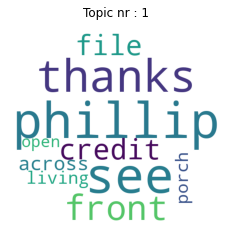

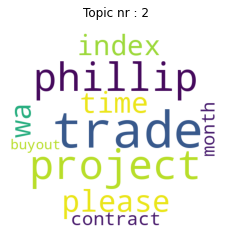

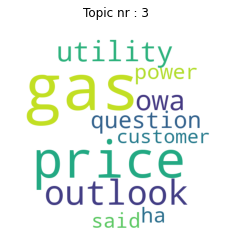

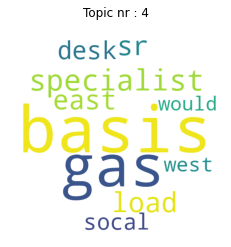

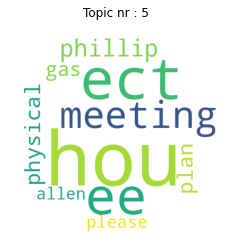

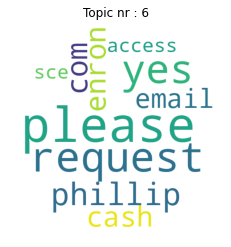

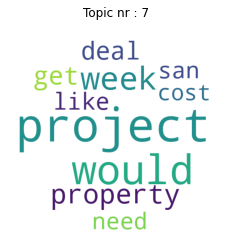

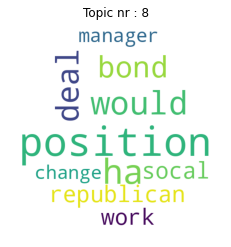

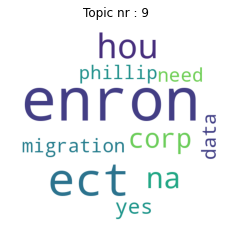

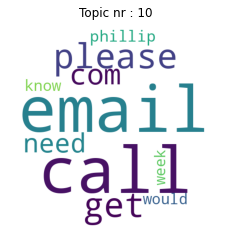

In [13]:
print("Wordcloud of topics for the common dictionary.\n")
plot_wordcloud(model_common)

## Conducting a search for the number of topics

Topic coherence is used to conduct a search for the number of topics.  %Still need to study this in more detail%.
The basic idea is keeping the model hyperparameters fixed, and iterating through the number of topics.  The lower limit and step can be adjusted as required.  Plotting a graph of the scores makes it easier to evaluate the performance of the model across topics.


jupyter labextension install jupyterlab-plotly

100%|███████████████████████████████████████████| 18/18 [08:31<00:00, 28.41s/it]


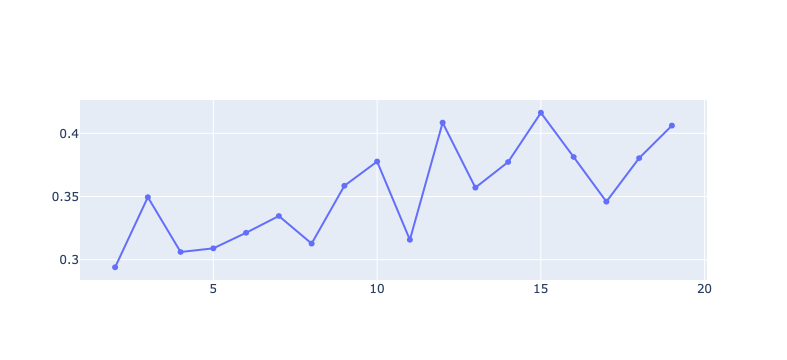

In [4]:
common_scores = score_topics(dictionary_common, bow_docs_common, texts_common, start = 2, step = 1, stop = 20)
    
plot_topic_scores(common_scores)        

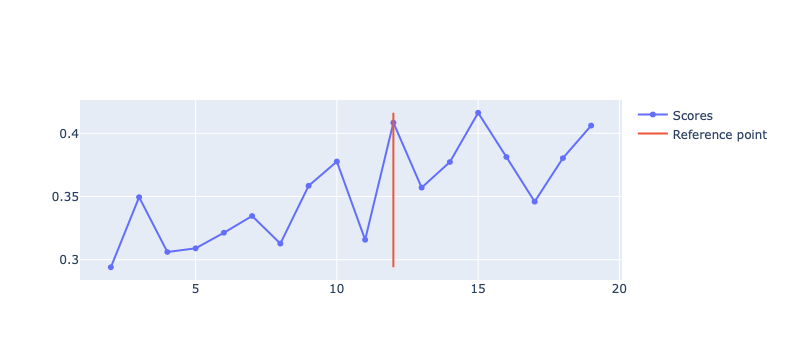

In [6]:
plot_topic_scores(common_scores, reference = 12)  

### Interpretation

The graph above varies.  By hovering over a point, the exact score can be seen.  A similar score exist for 8 and 17 topics.  Plotting wordclouds for some chosen points may provide more insight into what is happening.

No of topics:  7 




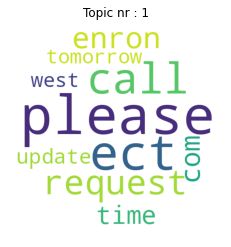

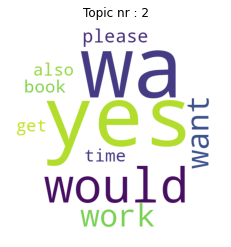

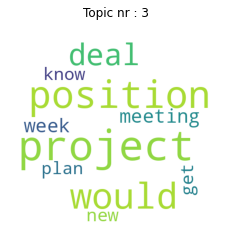

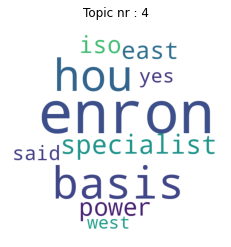

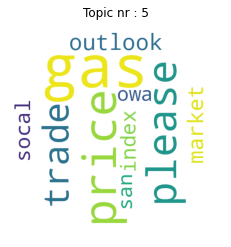

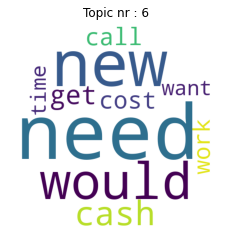

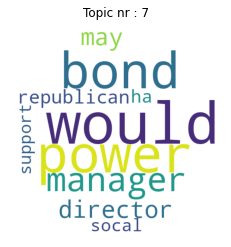

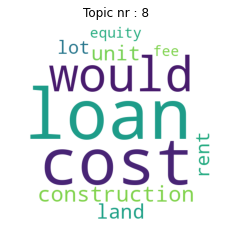


-------------------

No of topics:  12 




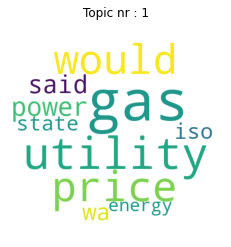

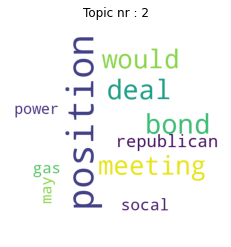

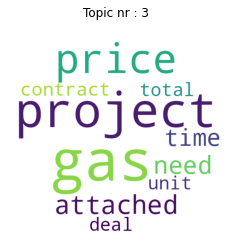

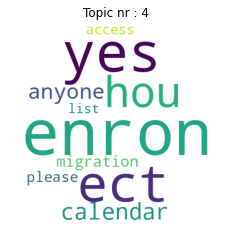

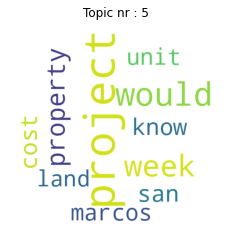

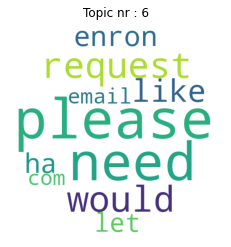

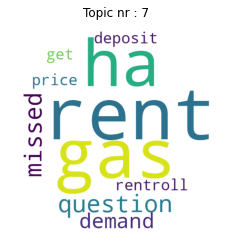

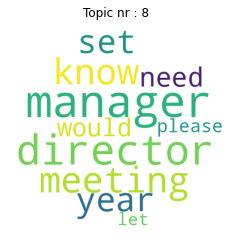

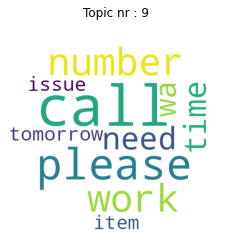

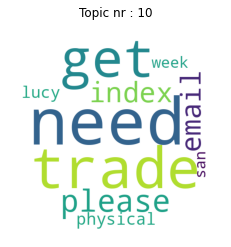


-------------------



In [7]:
plot_list = [7,12]

for nr_topics in plot_list:
    print("No of topics: ",nr_topics,"\n\n")
    plot_wordcloud(common_scores[nr_topics - 1][2])
    print('\n-------------------\n')


It is very difficult to assess based on the above.  For now, the only advantage is that there is a way to select number of topics from a graph.

# Experimenting with pre-processing for optimisation

For the purposes of experimenting with pre-processing, a seperate directory "experimental_data" was created.  Files pre-processed in this directory has different pre_pend strings to the names:
1. Basic_: Only basic pre-processing was performed.
1. Mailer_ : The javamailer style email addresses were filtered out.
1. Name_ : The name of the person who the mails belong to was filtered out.

Each pre-process includes the previous pre_processes filters.  For the basic experiments we fix the number of topics at 10 (an arbitratruy choice), and use wordclouds to subjectively assess the quality of the pre-processing by considering how well the words group together, and how many words we spot which are clearly not supposed to be used in topic classification.

## Basic pre_processing


Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  602
Number of documents in the POS corpus:  602
Training topics for common model

Wordcloud of topics for the basic pre-processing.



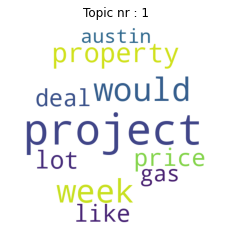

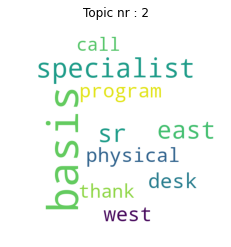

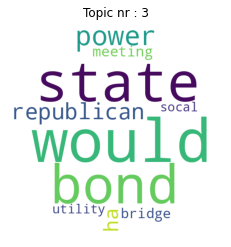

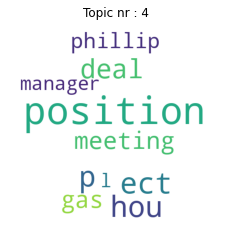

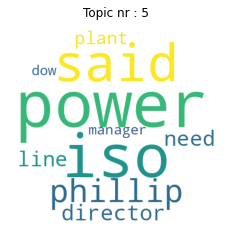

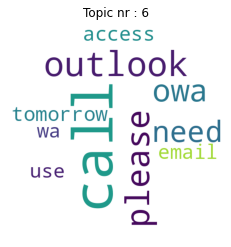

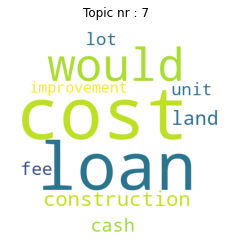

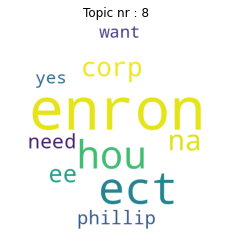

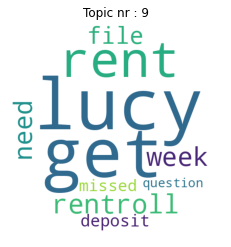

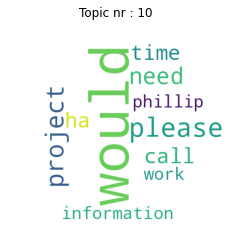

In [27]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail')

bow_docs_common,dictionary_common,texts_common,_,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "Basic_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 12


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common)


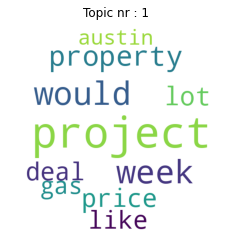

Saving:  Experiment1_Wordcloud_basic_topic_1.png


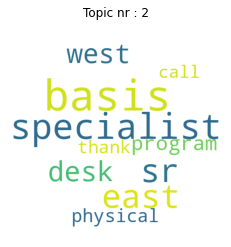

Saving:  Experiment1_Wordcloud_basic_topic_2.png


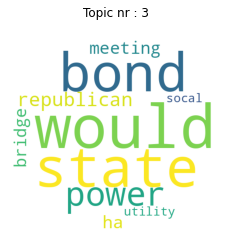

Saving:  Experiment1_Wordcloud_basic_topic_3.png


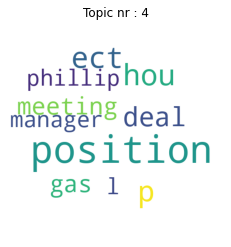

Saving:  Experiment1_Wordcloud_basic_topic_4.png


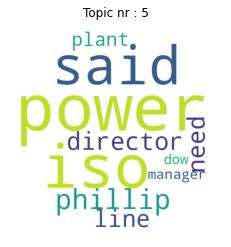

Saving:  Experiment1_Wordcloud_basic_topic_5.png


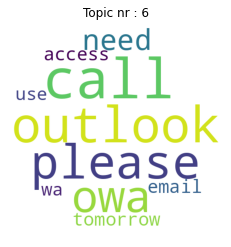

Saving:  Experiment1_Wordcloud_basic_topic_6.png


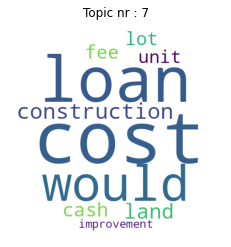

Saving:  Experiment1_Wordcloud_basic_topic_7.png


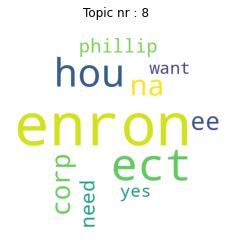

Saving:  Experiment1_Wordcloud_basic_topic_8.png


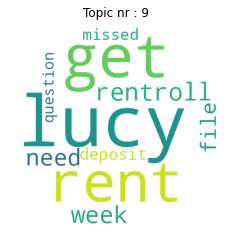

Saving:  Experiment1_Wordcloud_basic_topic_9.png


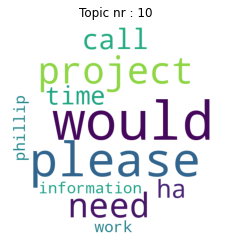

Saving:  Experiment1_Wordcloud_basic_topic_10.png


In [28]:
plot_wordcloud(model_common,filename = 'Experiment1_Wordcloud_basic')

It is clear from the wordclouds that "ECT", "HOU" and "Enron" dominate many of the topics.   Upon closer inspection of the actual emails, these terms occur in the email address format used by the javamailer.  This type of information is of no consequence and should be removed.

## Filtering out the javamailer addresses

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  602
Number of documents in the POS corpus:  602
Training topics for common model

Wordcloud of topics for the basic pre-processing and additionally filtering out java mailer addresses.



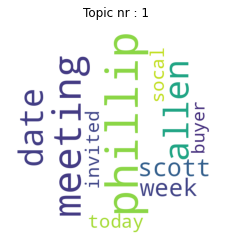

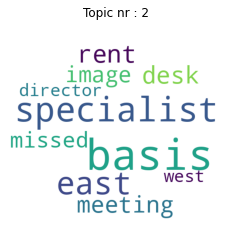

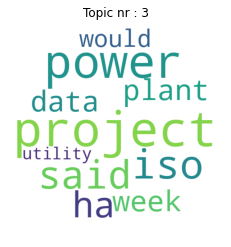

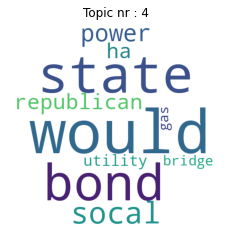

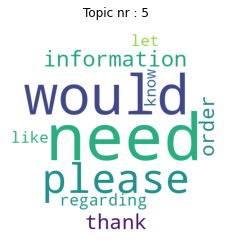

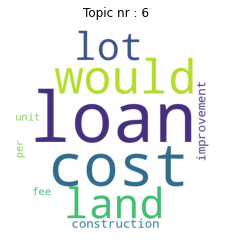

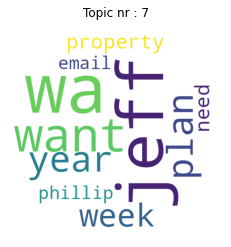

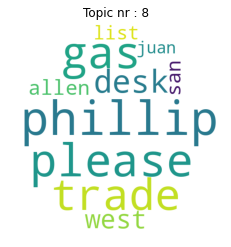

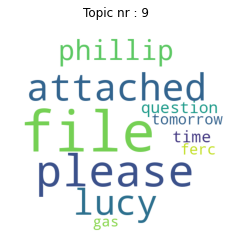

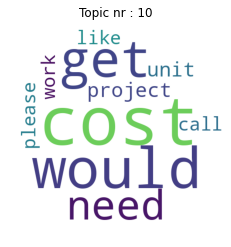

In [29]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail')

bow_docs_common,dictionary_common,texts_common,_,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "Mailer_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 12


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing and additionally filtering out java mailer addresses.\n")
plot_wordcloud(model_common)



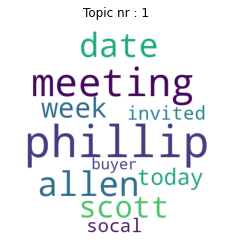

Saving:  Experiment1_JavamailerFilter_topic_1.png


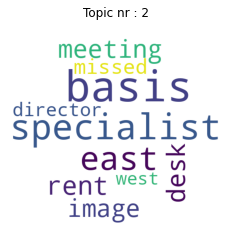

Saving:  Experiment1_JavamailerFilter_topic_2.png


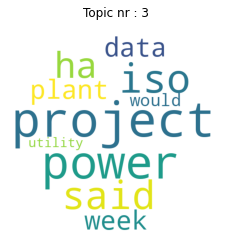

Saving:  Experiment1_JavamailerFilter_topic_3.png


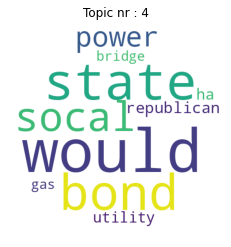

Saving:  Experiment1_JavamailerFilter_topic_4.png


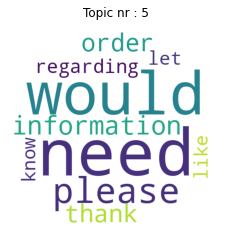

Saving:  Experiment1_JavamailerFilter_topic_5.png


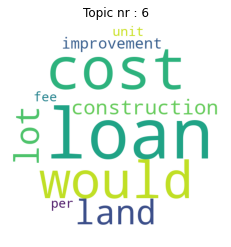

Saving:  Experiment1_JavamailerFilter_topic_6.png


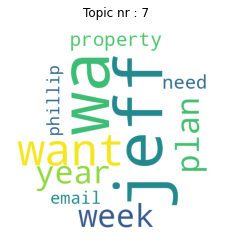

Saving:  Experiment1_JavamailerFilter_topic_7.png


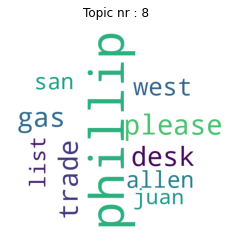

Saving:  Experiment1_JavamailerFilter_topic_8.png


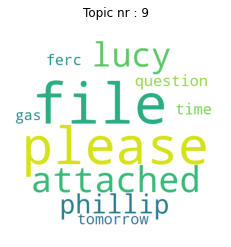

Saving:  Experiment1_JavamailerFilter_topic_9.png


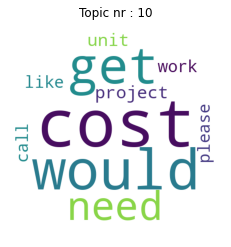

Saving:  Experiment1_JavamailerFilter_topic_10.png


In [30]:
plot_wordcloud(model_common,filename = 'Experiment1_JavamailerFilter')

Notice that the mailbox owner name and surname tend to dominate.  This is probably due to the mailbox owner's name or surname appear in his message signature, as this is the sent mail doirectory of Phillap Allen.  We expect something similar to happen in for instance the "all_documents" folder.

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  628
Number of documents in the POS corpus:  628
Training topics for common model

Wordcloud of topics for the basic pre-processing and additionally filtering out java mailer addresses.



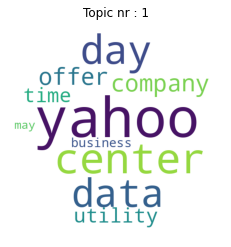

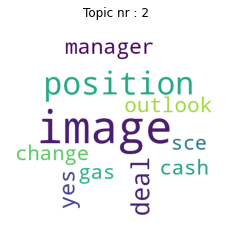

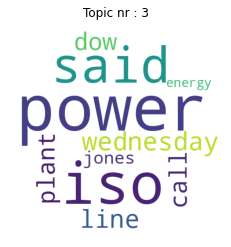

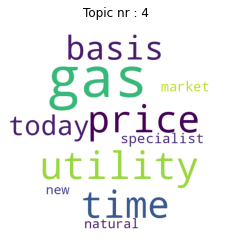

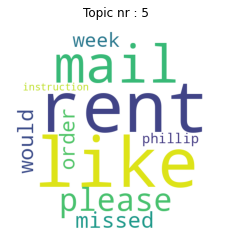

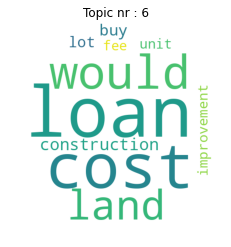

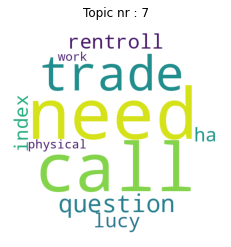

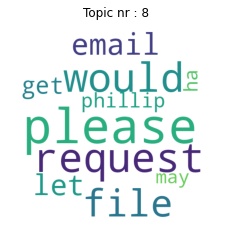

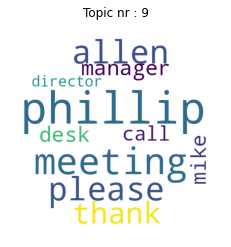

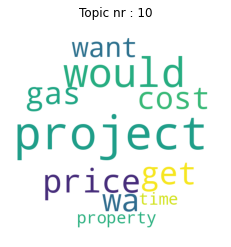

In [31]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','all_documents')
#subdir = os.path.join(maildir_path,'allen-p','_sent_mail')


bow_docs_common,dictionary_common,texts_common,_,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "Mailer_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 12


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing and additionally filtering out java mailer addresses.\n")
plot_wordcloud(model_common)




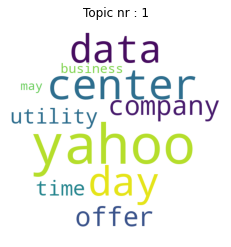

Saving:  JavaMailer_AllDocs_topic_1.png


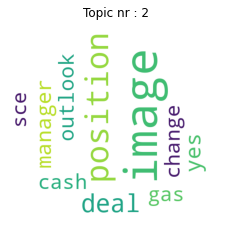

Saving:  JavaMailer_AllDocs_topic_2.png


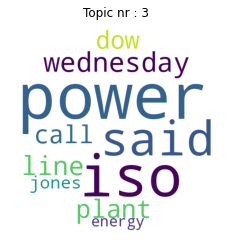

Saving:  JavaMailer_AllDocs_topic_3.png


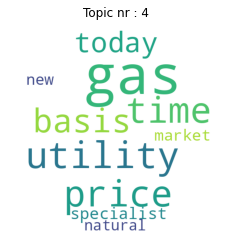

Saving:  JavaMailer_AllDocs_topic_4.png


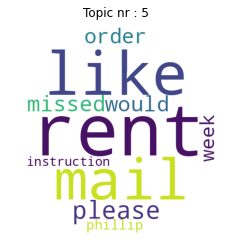

Saving:  JavaMailer_AllDocs_topic_5.png


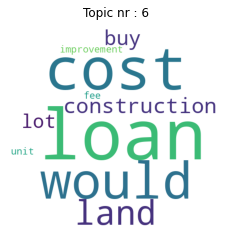

Saving:  JavaMailer_AllDocs_topic_6.png


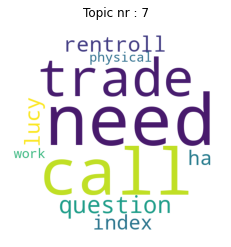

Saving:  JavaMailer_AllDocs_topic_7.png


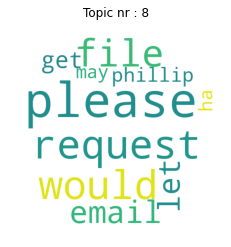

Saving:  JavaMailer_AllDocs_topic_8.png


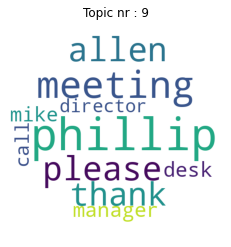

Saving:  JavaMailer_AllDocs_topic_9.png


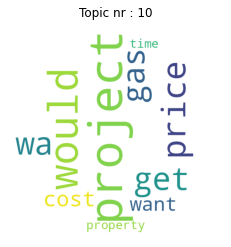

Saving:  JavaMailer_AllDocs_topic_10.png


In [32]:
plot_wordcloud(model_common,filename = 'JavaMailer_AllDocs')

It seems necessary to filter out the name of the mailbox owner, which is the next filter that we apply.

## Filtering the mailbox owner name

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  602
Number of documents in the POS corpus:  602
Training topics for common model

Wordcloud of topics for the basic pre-processing, as well as java mailer and mailbox owner.



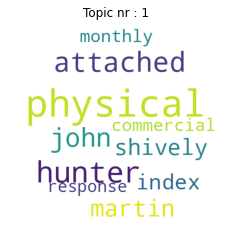

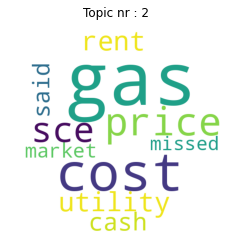

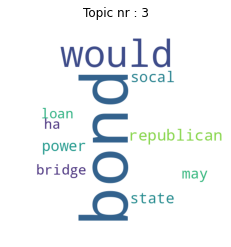

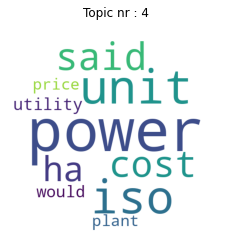

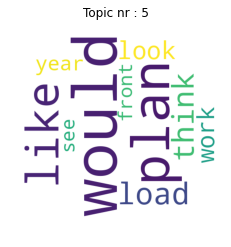

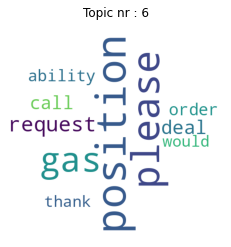

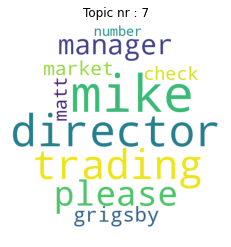

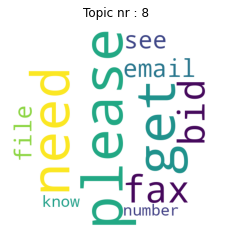

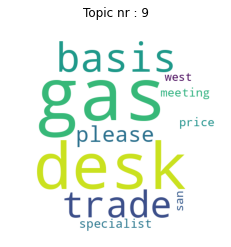

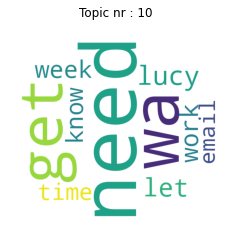

In [33]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail')

bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir, pre_pend_filter = "Name_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 12


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing, as well as java mailer and mailbox owner.\n")
plot_wordcloud(model_common)

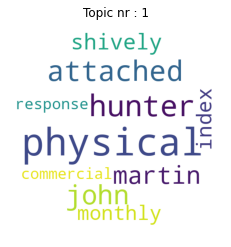

Saving:  Experiment1_MailboxOwner_topic_1.png


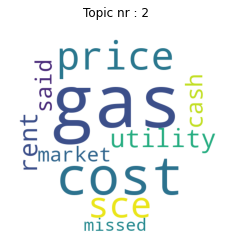

Saving:  Experiment1_MailboxOwner_topic_2.png


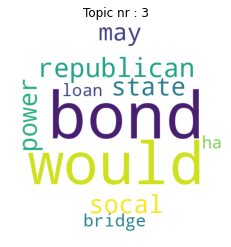

Saving:  Experiment1_MailboxOwner_topic_3.png


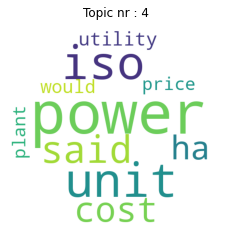

Saving:  Experiment1_MailboxOwner_topic_4.png


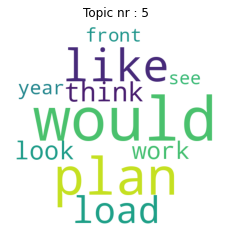

Saving:  Experiment1_MailboxOwner_topic_5.png


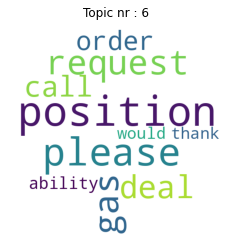

Saving:  Experiment1_MailboxOwner_topic_6.png


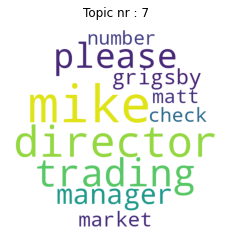

Saving:  Experiment1_MailboxOwner_topic_7.png


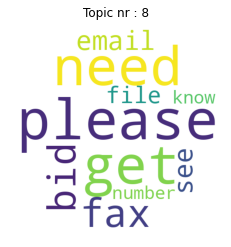

Saving:  Experiment1_MailboxOwner_topic_8.png


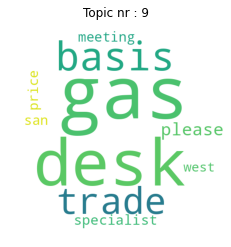

Saving:  Experiment1_MailboxOwner_topic_9.png


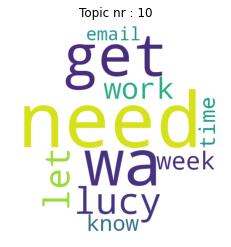

Saving:  Experiment1_MailboxOwner_topic_10.png


In [34]:
plot_wordcloud(model_common,filename = 'Experiment1_MailboxOwner')

The topics visually seem to be improving in terms of word groupings.  To confirm, we repeat this for the "all_documents" folder as well.

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  628
Number of documents in the POS corpus:  628
Training topics for common model

Wordcloud of topics for the basic pre-processing.



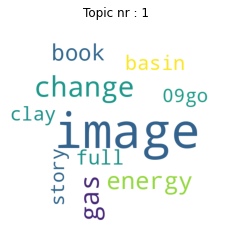

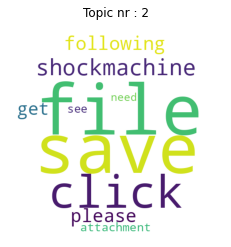

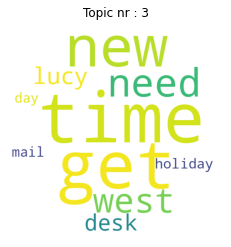

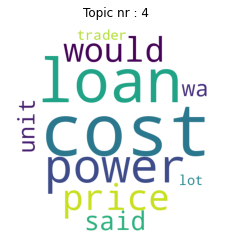

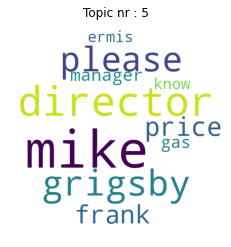

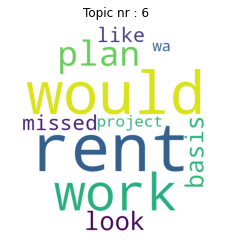

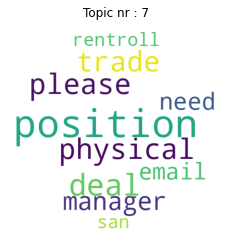

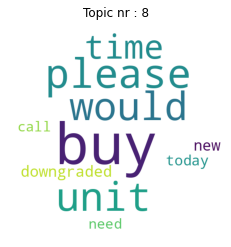

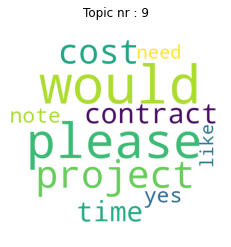

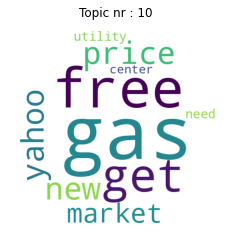

In [35]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','all_documents')

bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir, pre_pend_filter = "Name_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 12


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common)



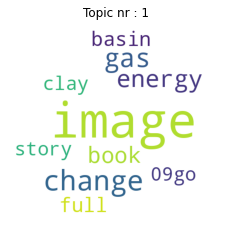

Saving:  Experiment1_MailboxOwner_AllDocs_topic_1.png


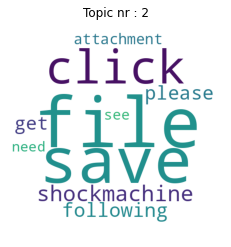

Saving:  Experiment1_MailboxOwner_AllDocs_topic_2.png


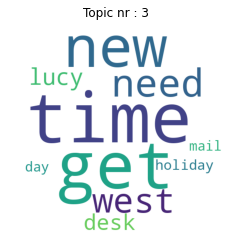

Saving:  Experiment1_MailboxOwner_AllDocs_topic_3.png


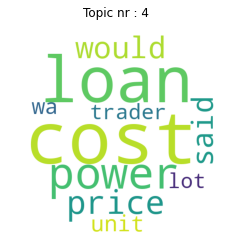

Saving:  Experiment1_MailboxOwner_AllDocs_topic_4.png


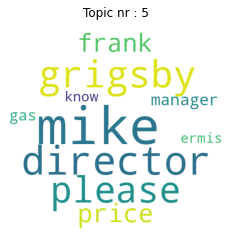

Saving:  Experiment1_MailboxOwner_AllDocs_topic_5.png


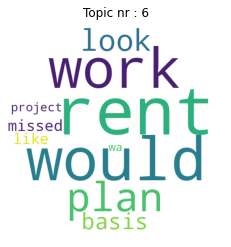

Saving:  Experiment1_MailboxOwner_AllDocs_topic_6.png


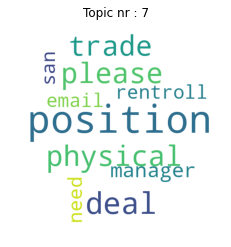

Saving:  Experiment1_MailboxOwner_AllDocs_topic_7.png


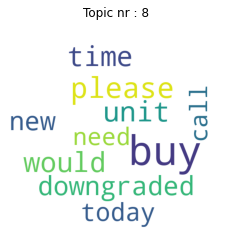

Saving:  Experiment1_MailboxOwner_AllDocs_topic_8.png


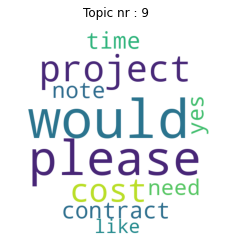

Saving:  Experiment1_MailboxOwner_AllDocs_topic_9.png


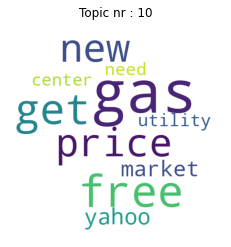

Saving:  Experiment1_MailboxOwner_AllDocs_topic_10.png


In [36]:
plot_wordcloud(model_common,filename = 'Experiment1_MailboxOwner_AllDocs')

Indeed, the topics seem to improve.

## Comparing Part of Speech tagging vs General Processing

Another method to extract the words was already applied, namely Part of Speech tagging (POS) and extracting only proper nouns, nouns and verbs for topic training.  Below is a wordcloud for the same data based on these topics.


Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  602
Number of documents in the POS corpus:  602
Training topics for POS model

Wordcloud of topics for the POS pre-processing.



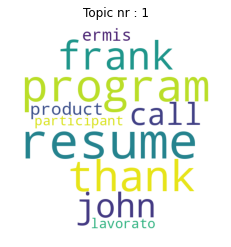

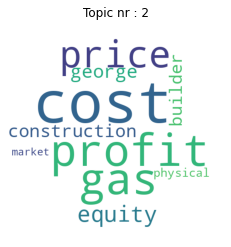

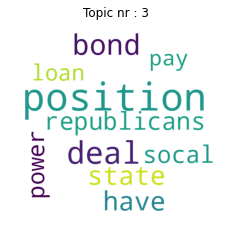

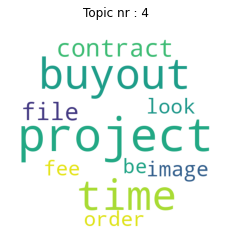

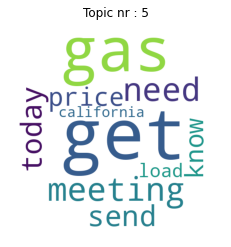

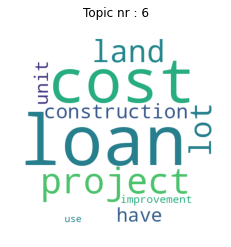

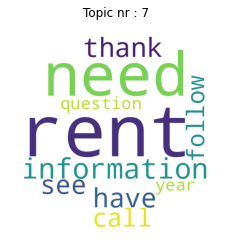

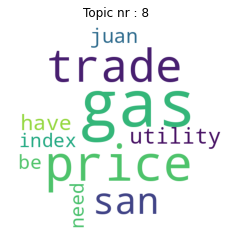

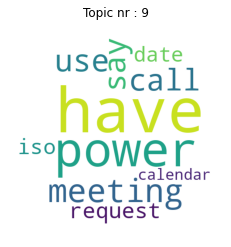

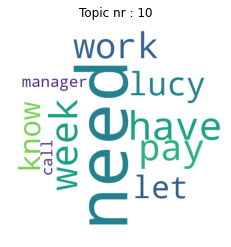

In [41]:
# Define and train the LDA models

maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
#subdir = os.path.join(maildir_path,'allen-p','all_documents')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail')


_,_,_,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir, pre_pend_filter = "Name_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 12





num_pos = 12
print('Training topics for POS model\n')
model_pos = build_LDA_model(dictionary_pos, bow_docs_pos, num_topics = num_pos)

print("Wordcloud of topics for the POS pre-processing.\n")
plot_wordcloud(model_pos)



Subjectively the topics do seem to be coherent, but it is difficult to judge between the POS and Common models.  A better measure will need to be used eventually.

## Investigating the effect of choosing different number of topics

The code below trains both models for a selection on the number of topics.  Each model is saved in the background so that it can later be reused after selection.

In [ ]:
#common_scores = score_topics(dictionary_pos, bow_docs_pos, texts_pos, stop = 50)
#pos_scores = score_topics(dictionary_common, bow_docs_common, texts_common, stop = 50)

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  628
Number of documents in the POS corpus:  628
Training topics for common model

Wordcloud of topics for the basic pre-processing.



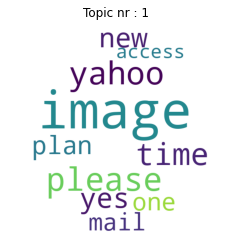

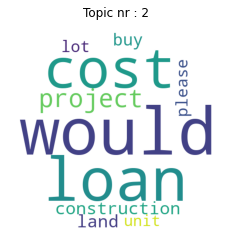

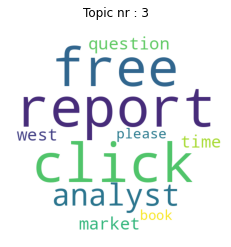

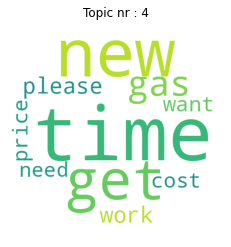

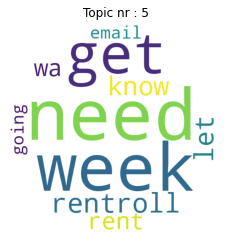

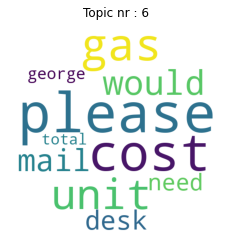

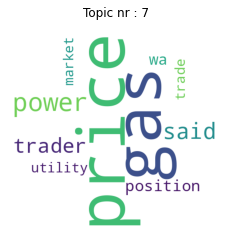

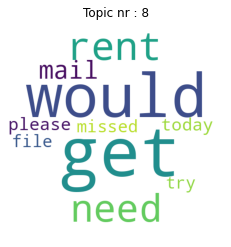

Training topics for common model

Wordcloud of topics for the basic pre-processing.



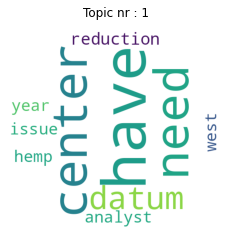

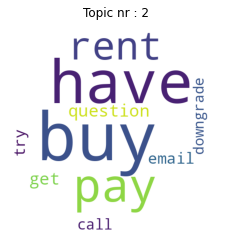

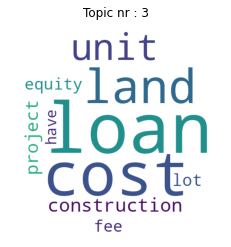

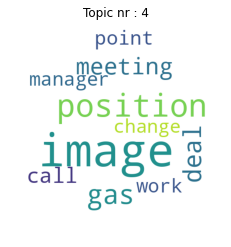

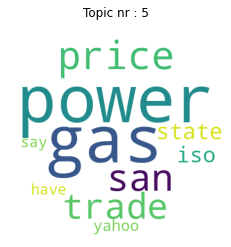

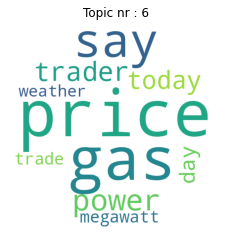

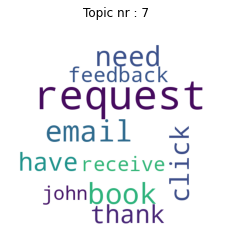

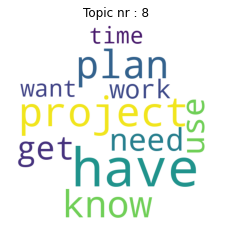

In [10]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','all_documents')

bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir, pre_pend_filter = "Full_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 8


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common)

# Define and train the LDA models
print('Training topics for common model\n')
model_pos = build_LDA_model(dictionary_pos, bow_docs_pos, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_pos)


100%|███████████████████████████████████████████| 49/49 [10:16<00:00, 12.58s/it]


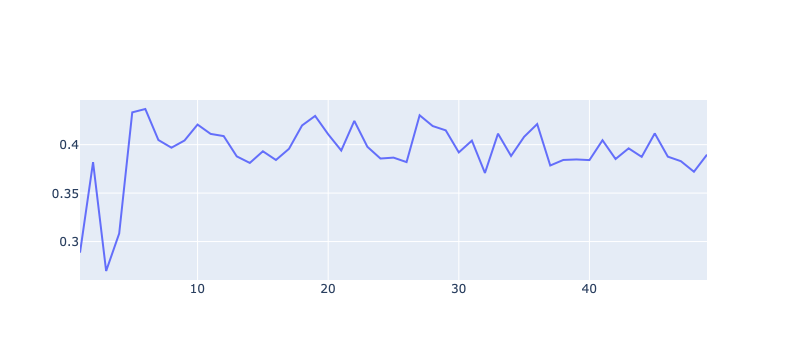

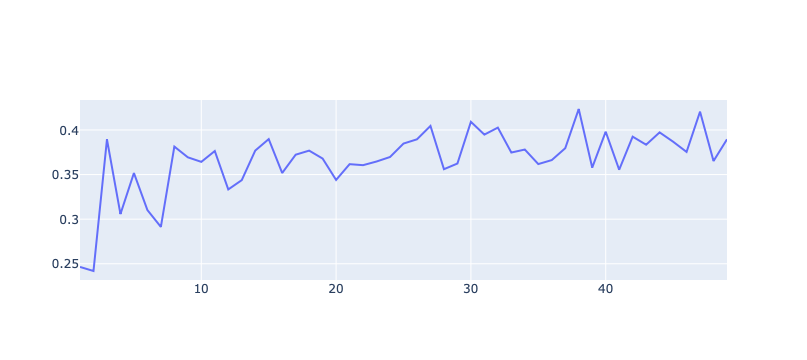

In [13]:
pos_scores = score_topics(dictionary_pos, bow_docs_pos, texts_pos, stop = 50)
common_scores = score_topics(dictionary_common, bow_docs_common, texts_common, stop = 50)

plot_topic_scores(pos_scores)    
plot_topic_scores(common_scores)        

In [6]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

# Define and train the LDA models
# Train pos models
num_pos = 4
print('Training topics for POS model: ',num_pos,' topics\n')
model_pos_4 = build_LDA_model(dictionary_pos, bow_docs_pos, num_topics = num_pos)

num_pos = 11
print('Training topics for POS model: ',num_pos,' topics\n')
model_pos_11 = build_LDA_model(dictionary_pos, bow_docs_pos, num_topics = num_pos)

num_pos = 45
print('Training topics for POS model: ',num_pos,' topics\n')
model_pos_45 = build_LDA_model(dictionary_pos, bow_docs_pos, num_topics = num_pos)

# Train common models
num_common = 10
print('Training topics for Common model: ',num_common,' topics\n')
model_common_10 = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_common)

num_common = 23
print('Training topics for Common model: ',num_common,' topics\n')
model_common_23 = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_common)

num_common = 45
print('Training topics for Common model: ',num_common,' topics\n')
model_common_45 = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_common)

vis_pos_4 = pyLDAvis.gensim_models.prepare(model_pos_4, bow_docs_pos,dictionary_pos)
vis_pos_11 = pyLDAvis.gensim_models.prepare(model_pos_11, bow_docs_pos,dictionary_pos)
vis_pos_45 = pyLDAvis.gensim_models.prepare(model_pos_45, bow_docs_pos,dictionary_pos)

vis_common_10 = pyLDAvis.gensim_models.prepare(model_common_10, bow_docs_common,dictionary_common)
vis_common_23 = pyLDAvis.gensim_models.prepare(model_common_23, bow_docs_common,dictionary_common)
vis_common_45 = pyLDAvis.gensim_models.prepare(model_common_45, bow_docs_common,dictionary_common)

pyLDAvis.save_html(vis_pos_4, "pos_model_vis_4_topics.html")
pyLDAvis.save_html(vis_pos_11, "pos_model_vis_11_topics.html")
pyLDAvis.save_html(vis_pos_45, "pos_model_vis_45_topics.html")

pyLDAvis.save_html(vis_common_10, "common_model_vis_10_topics.html")
pyLDAvis.save_html(vis_common_23, "common_model_vis_23_topics.html")
pyLDAvis.save_html(vis_common_45, "common_model_vis_45_topics.html")

Training topics for POS model:  4  topics

Training topics for POS model:  11  topics

Training topics for POS model:  45  topics

Training topics for Common model:  10  topics

Training topics for Common model:  23  topics

Training topics for Common model:  45  topics



Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  602
Number of documents in the POS corpus:  602
Training models for common dictionary


100%|███████████████████████████████████████████| 20/20 [06:50<00:00, 20.53s/it]


Training models for POS dictionary


100%|███████████████████████████████████████████| 20/20 [05:25<00:00, 16.26s/it]

Common scores


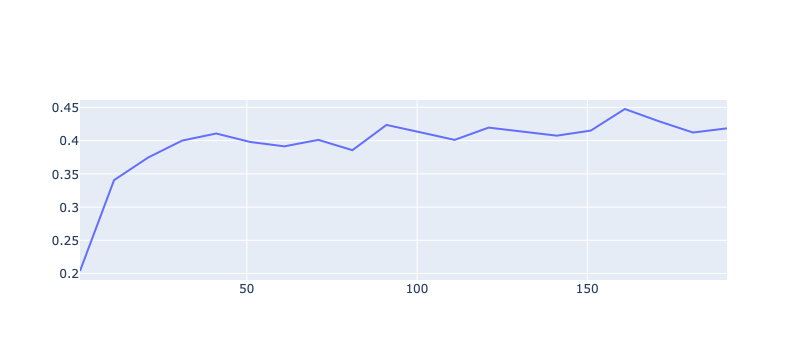

POS scores


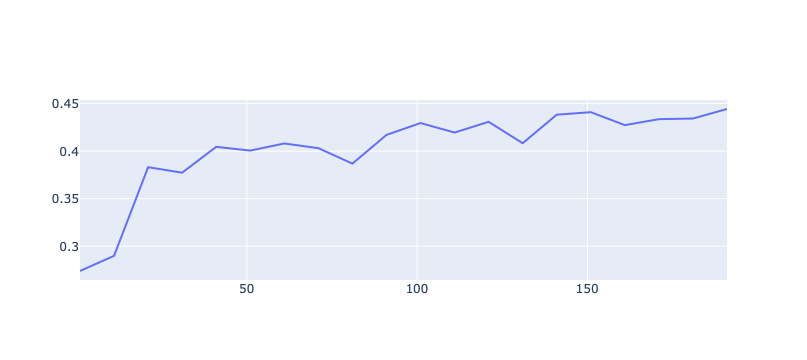

In [14]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail')
#subdir = os.path.join(maildir_path,'allen-p')

bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir,pre_pend_filter = "Full_")

print("Training models for common dictionary")
common_scores = score_topics(dictionary_common, bow_docs_common, texts_common, start = 1, stop = 200, step = 10)
print("Training models for POS dictionary")
pos_scores = score_topics(dictionary_pos, bow_docs_pos, texts_pos, start = 1, stop = 200, step = 10)
    
print("Common scores")
plot_topic_scores(common_scores)
print("POS scores")
plot_topic_scores(pos_scores) 


## Document topic scoring

## Document subset experiments

### Newsletter subset

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  149
Number of documents in the POS corpus:  149
Training models for common dictionary


100%|███████████████████████████████████████████| 19/19 [02:06<00:00,  6.68s/it]


Training models for POS dictionary


100%|███████████████████████████████████████████| 19/19 [01:49<00:00,  5.75s/it]

Common scores


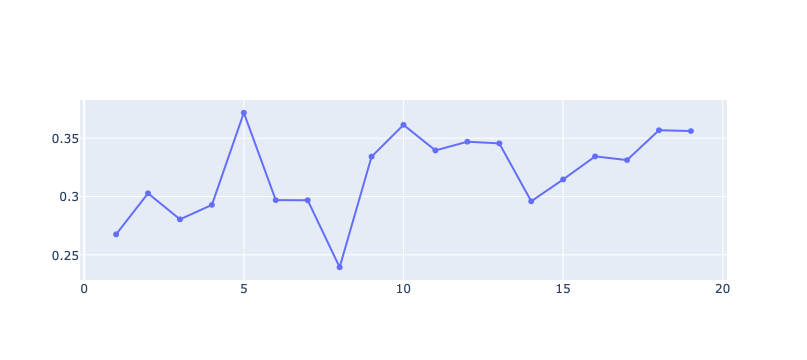

POS scores


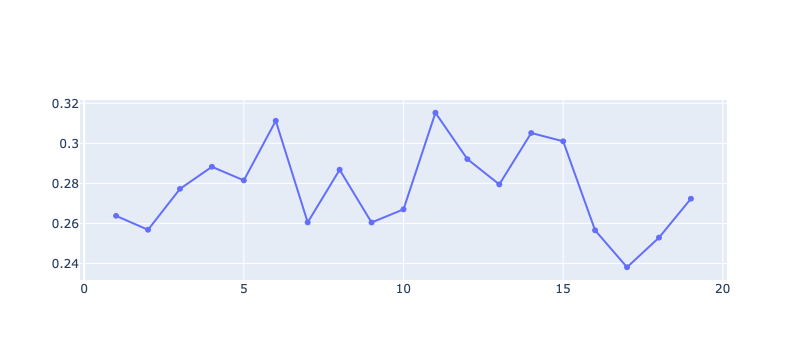

In [15]:
maildir_path = os.path.join('..','..','data', 'processed')
subdir = os.path.join(maildir_path,'Multex')

bow_docs_common_full,dictionary_common,texts_common,bow_docs_pos_full,dictionary_pos,texts_pos,files = build_dictionaries(subdir, pre_pend_filter = "")

bow_docs_pos = bow_docs_pos_full[:10]
bow_docs_common = bow_docs_common_full[:10]


print("Training models for common dictionary")
common_scores = score_topics(dictionary_common, bow_docs_common, texts_common, start = 1, stop = 20, step = 1)
print("Training models for POS dictionary")
pos_scores = score_topics(dictionary_pos, bow_docs_pos, texts_pos, start = 1, stop = 20, step = 1)
    
print("Common scores")
plot_topic_scores(common_scores)
print("POS scores")
plot_topic_scores(pos_scores) 



In [4]:
# Define and train the LDA models
# Train pos models
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir, pre_pend_filter = "")

num_pos = 4
print('Training topics for POS model: ',num_pos,' topics\n')
model_Multex_pos_11 = build_LDA_model(dictionary_pos, bow_docs_pos, num_topics = num_pos)


vis_Multex_pos_11 = pyLDAvis.gensim_models.prepare(model_Multex_pos_11, bow_docs_pos,dictionary_pos)

pyLDAvis.save_html(vis_Multex_pos_11, "pos_model_Multex_vis_11_topics.html")


Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3010
Number of documents in the POS corpus:  3010
Training topics for POS model:  4  topics



/Users/riaal/.pyenv/versions/3.9.6/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/riaal/.pyenv/versions/3.9.6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/riaal/.pyenv/versions/3.9.6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/riaal/.pyenv/versions/3.9.6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ria

In [5]:
v1 = vectorise(model_Multex_pos_11.get_document_topics(bow_docs_pos[1]),4)      
v2 = vectorise(model_Multex_pos_11.get_document_topics(bow_docs_pos[1]),4)   

print(v1)
print(v2)

angle = cosine_sim(v1,v2)    
print(100 * (90 - angle) / 90)


[0.29095873, 0.2792418, 0.23972405, 0.19007544]
[0.29095873, 0.2792418, 0.23972405, 0.19007544]
100.0


In [6]:
model_Multex_pos_11.get_document_topics(bow_docs_common[95])

[(0, 0.14862476), (1, 0.07766287), (2, 0.5499545), (3, 0.22375785)]

In [7]:
reference_vector = vectorise(model_Multex_pos_11.get_document_topics(bow_docs_common[1]),4)

for i in range(0,len(bow_docs_common)):
    sample_vector = vectorise(model_Multex_pos_11.get_document_topics(bow_docs_common[i]),4)
    angle = cosine_sim(reference_vector,sample_vector)
#    print(sample_vector, " : ",angle , 100 * (90 - angle) / 90)
    print( sample_vector, ' : ' , 100 * (90 - angle) / 90 , i)

[0.50760305, 0.48977217, 0, 0]  :  58.68333602943777 0
[0.29095873, 0.2792418, 0.23972405, 0.19007544]  :  100.0 1
[0.5610181, 0.43712875, 0, 0]  :  58.241409407920465 2
[0.29095873, 0.2792418, 0.23972405, 0.19007544]  :  100.0 3
[0.29095873, 0.2792418, 0.23972405, 0.19007544]  :  100.0 4
[0.150053, 0.84748036, 0, 0]  :  44.49688428181282 5
[0.31250855, 0.22471096, 0, 0.45870012]  :  58.46877588929385 6
[0.39299175, 0, 0.23150119, 0.36810955]  :  59.92051649152314 7
[0.29095873, 0.2792418, 0.23972405, 0.19007544]  :  100.0 8
[0.7252185, 0.2700183, 0, 0]  :  52.20419031731669 9
[0, 0.41816676, 0.5799313, 0]  :  49.970838123286576 10
[0.7333024, 0.10412904, 0.103741184, 0.058827296]  :  52.40977113707597 11
[0.29095873, 0.2792418, 0.23972405, 0.19007544]  :  100.0 12
[0.931748, 0.044803366, 0.023028586, 0]  :  41.938029296410114 13
[0.29095873, 0.2792418, 0.23972405, 0.19007544]  :  100.0 14
[0.8052041, 0.12510508, 0.06949201, 0]  :  48.52726802228926 15
[0.6611052, 0, 0.3358318, 0]  :  

IndexError: index 4192 is out of bounds for axis 1 with size 4192

In [8]:
bow_reference = bow_docs_pos[11:110]

model_Multex_pos_11[bow_reference[1]]

reference_vector = vectorise(model_Multex_pos_11.get_document_topics(bow_docs_common[1]),11)
reference_vector[0] = 0
reference_vector[1] = 0.9
print(reference_vector)

for i in range(0,len(bow_reference)):
    sample_vector = vectorise(model_Multex_pos_11[bow_reference[i]],11)
    angle = cosine_sim(reference_vector,sample_vector)
#    print(sample_vector, " : ",angle , 100 * (90 - angle) / 90)
    print( sample_vector, ' : ' , 100 * (90 - angle) / 90 , i)

[0, 0.9, 0.23972405, 0.19007544, 0, 0, 0, 0, 0, 0, 0]
[0, 0.34782904, 0.65080714, 0, 0, 0, 0, 0, 0, 0, 0]  :  46.62941994366043 0
[0.29095873, 0.2792418, 0.23972405, 0.19007544, 0, 0, 0, 0, 0, 0, 0]  :  50.88046947402548 1
[0.9977174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  :  0.0 2
[0.29095873, 0.2792418, 0.23972405, 0.19007544, 0, 0, 0, 0, 0, 0, 0]  :  50.88046947402548 3
[0.9990435, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  :  0.0 4
[0, 0, 0.99245375, 0, 0, 0, 0, 0, 0, 0, 0]  :  16.230027345581295 5
[0.9897623, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  :  0.0 6
[0, 0.9943245, 0, 0, 0, 0, 0, 0, 0, 0, 0]  :  79.1396435167157 7
[0.99936354, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  :  0.0 8
[0, 0, 0.98424226, 0, 0, 0, 0, 0, 0, 0, 0]  :  16.230027345581295 9
[0, 0, 0.99842906, 0, 0, 0, 0, 0, 0, 0, 0]  :  16.230027345581295 10
[0.10710914, 0, 0, 0.8904308, 0, 0, 0, 0, 0, 0, 0]  :  12.723143736586783 11
[0, 0, 0.99664706, 0, 0, 0, 0, 0, 0, 0, 0]  :  16.230027345581295 12
[0.02529789, 0.9373325, 0.020843202, 0.016526422, 0, 0, 0, 

## Retrieval

_________________________________________________________
# End Notebook
________________


## Special experimentation section

In the section below we perform general experiments with code.  This will be deleted in the final notebook.

## Predicting topics

Given two models, let us attempt to predict topics on the emails.


In [ ]:
#### def extract_score(elem):
    return elem[1]

common_no_topics = 1
pos_no_topics = 1

_,_,model_common = common_scores[common_no_topics]
_,_,model_pos = pos_scores[pos_no_topics]

print(model_pos)

class_common = []
class_pos = []

# Initialise the lists to store the filenames
class_files_common = []
class_files_pos = []
for count in range(common_no_topics+1):
    class_files_common.append([])
    class_files_pos.append([])


# Classify the emails, and create lists
for bow_common,bow_pos,file in zip(bow_docs_common,bow_docs_pos,files):
    classification_common = model_common[bow_common]
    classification_pos = model_pos[bow_pos]
    class_common.append(classification_common)
    class_pos.append(classification_pos)    
    for topic in classification_common:
        class_files_common[topic[0]].append((file,topic[1]))
    for topic in classification_pos:
        class_files_pos[topic[0]].append((file,topic[1]))

# Sort the file lists in descending order of classification value in each topic
for topic_comm,topic_pos in zip(class_files_common,class_files_pos):
    topic_comm.sort(key=extract_score,reverse=True)
    topic_pos.sort(key=extract_score,reverse=True)



#print(class_files_pos[13])


print(len(class_common))
print(len(class_pos))

In [37]:
for topic in class_files_common[1]:
    file = os.path.join(subdir,topic[0])
    #file = topic[0]
    email = loadMail(file)
    print(email['body'])
    print('\n\n_______________\n\n')

please add mike grigsby to distribution list.



_______________


---------------------- Forwarded by Phillip K Allen/HOU/ECT on 04/02/2001 
02:49 PM ---------------------------


Parking & Transportation@ENRON
03/28/2001 02:07 PM
Sent by: DeShonda Hamilton@ENRON
To: Brad Alford/NA/Enron@Enron, Megan Angelos/Enron@EnronXGate, Suzanne 
Adams/HOU/ECT@ECT, John Allario/Enron@EnronXGate, Phillip K 
Allen/HOU/ECT@ECT, Irma Alvarez/Enron@EnronXGate, Airam Arteaga/HOU/ECT@ECT, 
Berney C Aucoin/HOU/ECT@ECT, Peggy Banczak/HOU/ECT@ECT, Robin 
Barbe/HOU/ECT@ECT, Edward D Baughman/Enron@EnronXGate, Pam 
Becton/Enron@EnronXGate, Corry Bentley/HOU/ECT@ECT, Patricia 
Bloom/Enron@EnronXGate, Sandra F Brawner/HOU/ECT@ECT, Jerry 
Britain/Enron@EnronXGate, Lisa Bills/Enron@EnronXGate, Michelle 
Blaine/ENRON@enronXgate, Eric Boyt/Corp/Enron@Enron, Cheryl 
Arguijo/Enron@EnronXGate, Jeff Ader/HOU/EES@EES, Mark Bernstein/HOU/EES@EES, 
Kimberly Brown/HOU/ECT@ECT, Gary Bryan/HOU/ECT@ECT, Rebecca W 
Cantrell/H

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte

In [35]:
array = model_pos.get_topics()
for score in array[0]:
    print(score)

3.7757414e-05
0.001012484
3.830141e-05
0.001560849
0.0023722474
0.004174106
0.019244423
3.775737e-05
0.0017515958
0.00036395257
3.9413397e-05
3.794902e-05
0.0002459718
0.0006191944
0.00021110252
0.0063355295
0.00051091786
3.776211e-05
0.0010627524
3.775749e-05
0.003078994
3.7757458e-05
0.0063084
0.00073869154
0.00019945626
4.345257e-05
0.0008963189
4.4872886e-05
0.0029925585
0.0041599297
0.0031360271
0.0017537562
0.006543444
0.00037946398
0.0024647801
0.010406178
0.00033767757
0.0006369068
0.00048782222
0.00033767766
0.00033767766
0.00033769195
0.00033767766
0.00033772763
0.00033767772
0.0001875231
0.0020976218
0.00050766696
0.0012900512
0.00048779263
0.00033767766
0.00088861206
0.0017855063
0.00033767766
0.0010869054
0.005672708
0.00033767766
0.00048779574
0.0010165211
0.00047590322
0.0029481726
0.000487822
0.00048070424
0.0005180774
0.0003376778
0.00044396988
0.0017569663
0.0014758025
0.0031804042
0.00040790933
0.0014741599
0.0010285958
0.0003376934
0.0006380613
0.0014772994
0.000661